In [1]:
def load_stopwords():
        """
        :return: 加载好的停用词列表
        """
        with open('../hit_stopwords.txt', 'r', encoding='UTF-8') as f:
            lines = f.readlines()
            stopwords = []
            for line in lines:
                stopwords.append(line.replace('\n', ''))
        return stopwords

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\DYL\AppData\Local\Temp\jieba.cache
Loading model cost 0.513 seconds.
Prefix dict has been built successfully.


375/375 [==============================] - 2s 6ms/step - loss: 0.1488 - accuracy: 0.9754
Test loss: 0.14881297945976257
Test accuracy: 0.9754146337509155
375/375 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5922
           1       0.98      0.97      0.98      6077

    accuracy                           0.98     11999
   macro avg       0.98      0.98      0.98     11999
weighted avg       0.98      0.98      0.98     11999



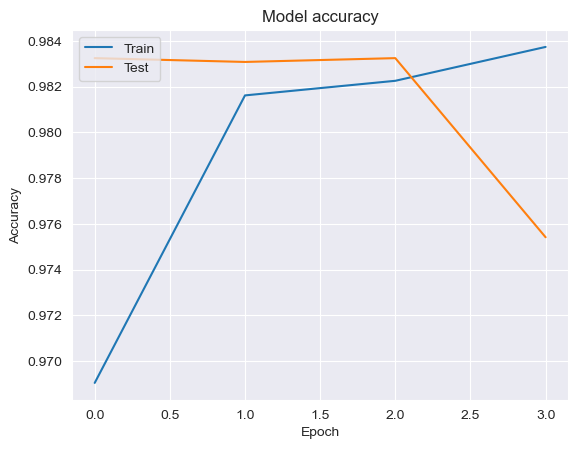

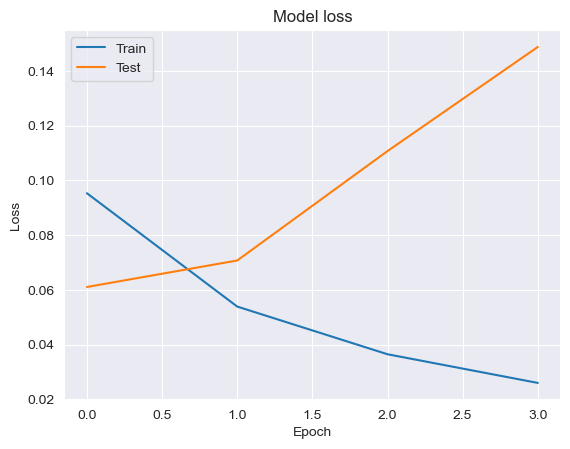

375/375 [==============================] - 2s 6ms/step - loss: 0.1477 - accuracy: 0.9728
Test loss: 0.1477084755897522
Test accuracy: 0.9728310704231262
375/375 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5922
           1       0.98      0.96      0.97      6077

    accuracy                           0.97     11999
   macro avg       0.97      0.97      0.97     11999
weighted avg       0.97      0.97      0.97     11999



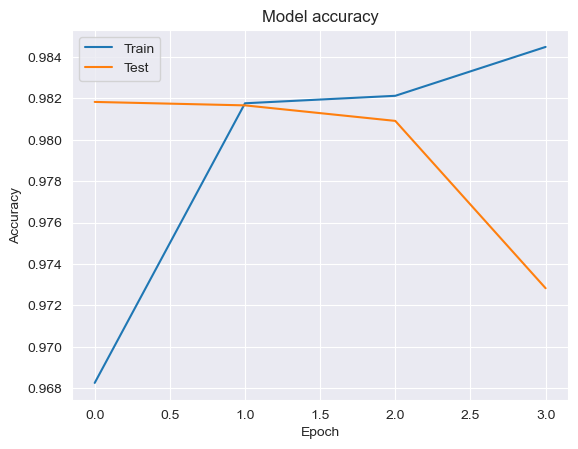

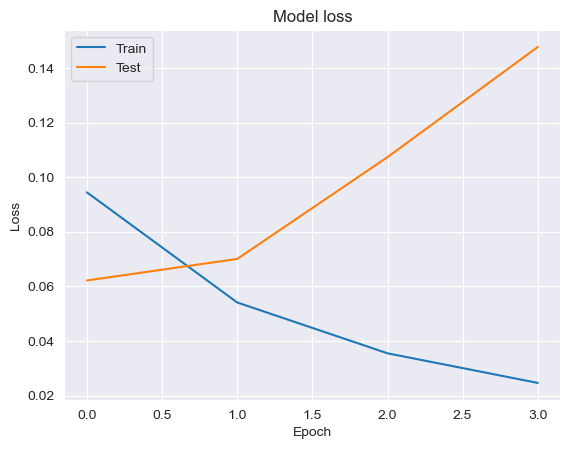

375/375 [==============================] - 2s 6ms/step - loss: 0.1582 - accuracy: 0.9706
Test loss: 0.158218115568161
Test accuracy: 0.9705808758735657
375/375 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5999
           1       0.98      0.96      0.97      6000

    accuracy                           0.97     11999
   macro avg       0.97      0.97      0.97     11999
weighted avg       0.97      0.97      0.97     11999



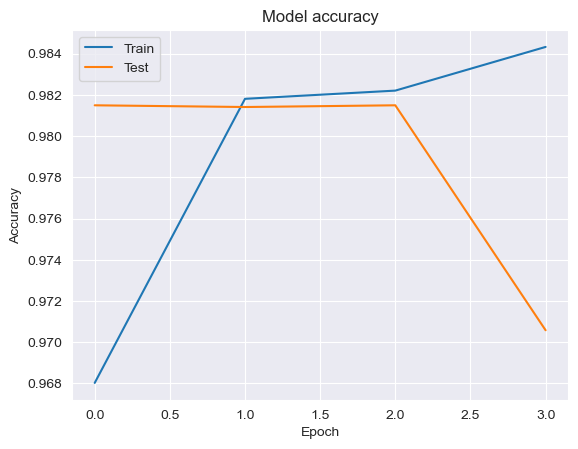

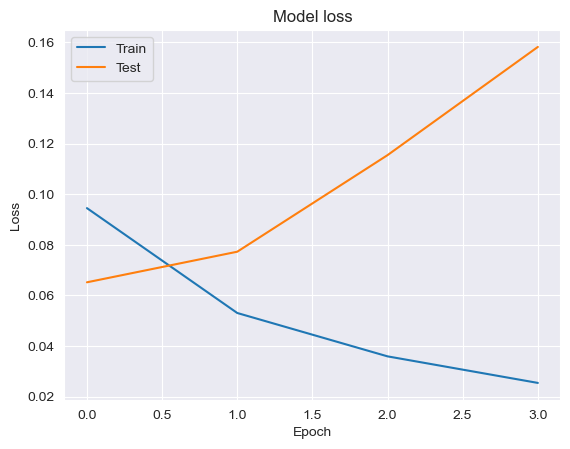

375/375 [==============================] - 2s 5ms/step - loss: 0.1415 - accuracy: 0.9710
Test loss: 0.1415160745382309
Test accuracy: 0.9709975719451904
375/375 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6056
           1       0.97      0.97      0.97      5943

    accuracy                           0.97     11999
   macro avg       0.97      0.97      0.97     11999
weighted avg       0.97      0.97      0.97     11999



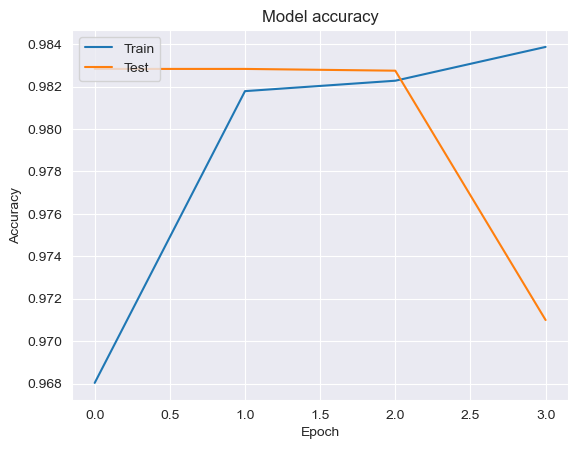

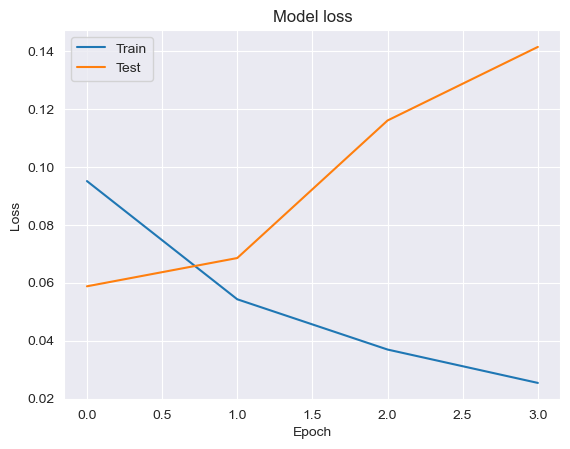

375/375 [==============================] - 2s 5ms/step - loss: 0.1153 - accuracy: 0.9726
Test loss: 0.11534927040338516
Test accuracy: 0.9725810289382935
375/375 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6008
           1       0.98      0.97      0.97      5991

    accuracy                           0.97     11999
   macro avg       0.97      0.97      0.97     11999
weighted avg       0.97      0.97      0.97     11999



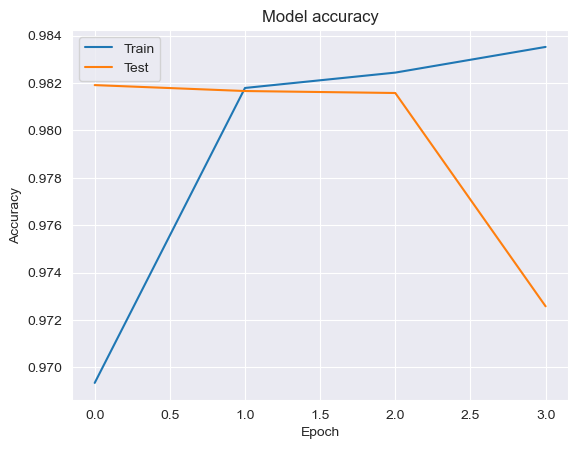

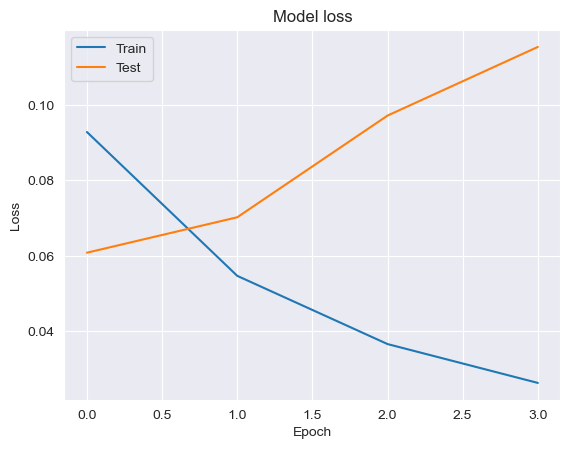

375/375 [==============================] - 2s 5ms/step - loss: 0.1184 - accuracy: 0.9750
Test loss: 0.11835786700248718
Test accuracy: 0.9749979376792908
375/375 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5965
           1       0.98      0.97      0.97      6034

    accuracy                           0.97     11999
   macro avg       0.98      0.98      0.97     11999
weighted avg       0.98      0.97      0.97     11999



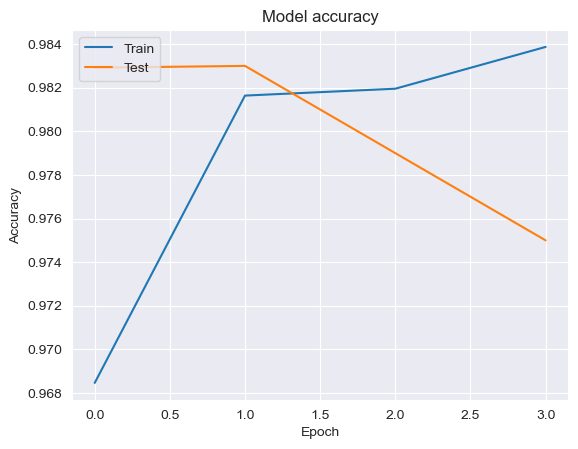

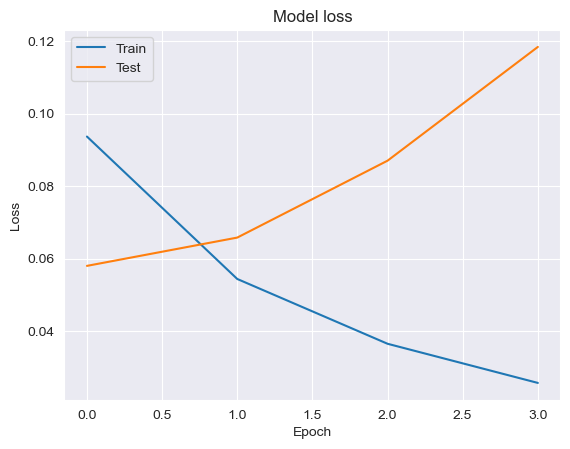

375/375 [==============================] - 2s 6ms/step - loss: 0.1564 - accuracy: 0.9661
Test loss: 0.15644019842147827
Test accuracy: 0.9660804867744446
375/375 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      6035
           1       0.97      0.96      0.97      5964

    accuracy                           0.97     11999
   macro avg       0.97      0.97      0.97     11999
weighted avg       0.97      0.97      0.97     11999



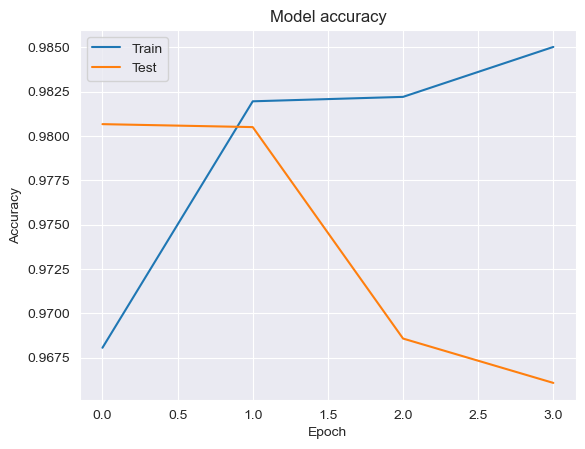

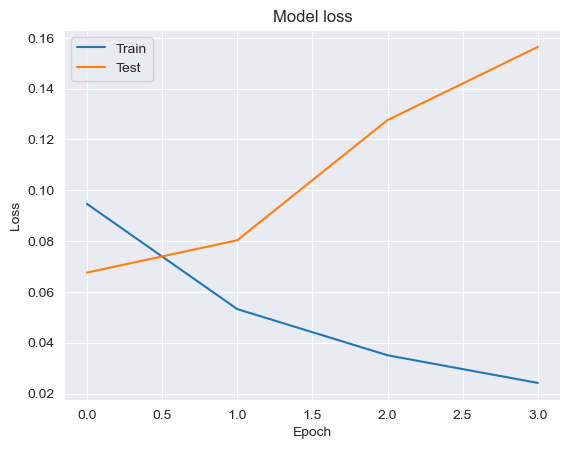

375/375 [==============================] - 2s 6ms/step - loss: 0.1455 - accuracy: 0.9726
Test loss: 0.14549775421619415
Test accuracy: 0.9725810289382935
375/375 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6116
           1       0.98      0.96      0.97      5883

    accuracy                           0.97     11999
   macro avg       0.97      0.97      0.97     11999
weighted avg       0.97      0.97      0.97     11999



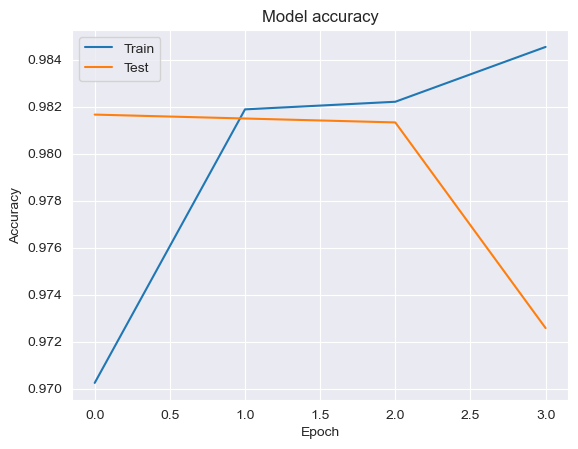

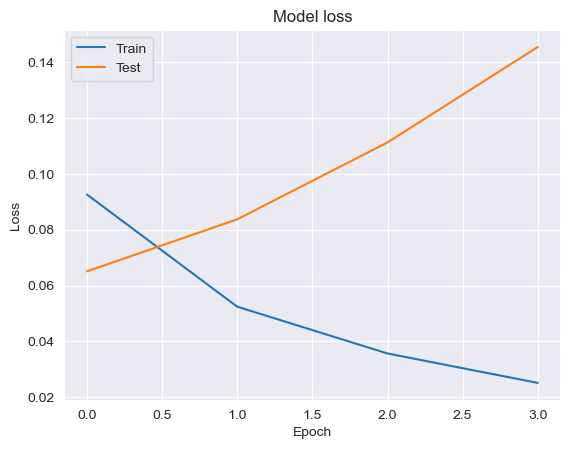

375/375 [==============================] - 2s 6ms/step - loss: 0.1404 - accuracy: 0.9712
Test loss: 0.14035701751708984
Test accuracy: 0.9711618423461914
375/375 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6012
           1       0.98      0.97      0.97      5986

    accuracy                           0.97     11998
   macro avg       0.97      0.97      0.97     11998
weighted avg       0.97      0.97      0.97     11998



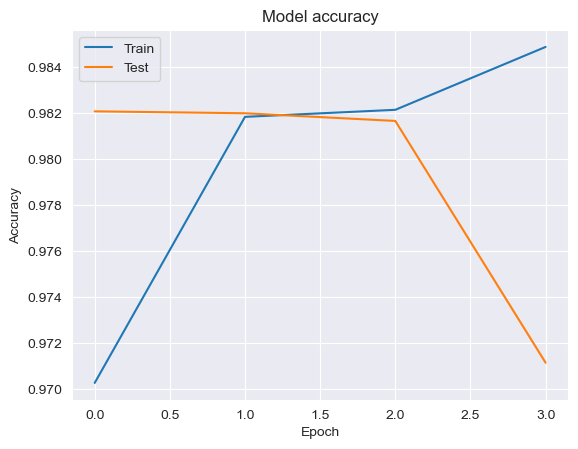

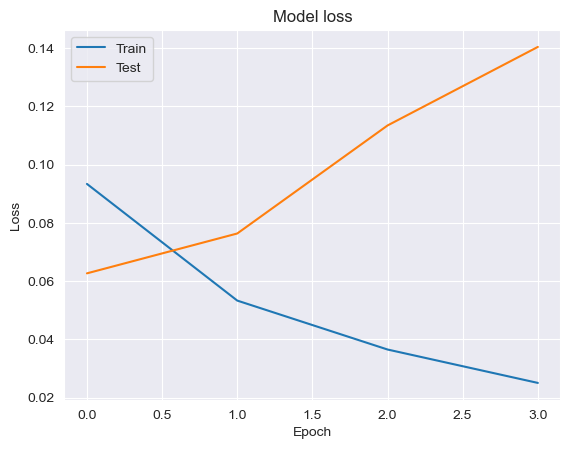

375/375 [==============================] - 2s 6ms/step - loss: 0.1460 - accuracy: 0.9690
Test loss: 0.145953968167305
Test accuracy: 0.9689948558807373
375/375 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5960
           1       0.97      0.97      0.97      6038

    accuracy                           0.97     11998
   macro avg       0.97      0.97      0.97     11998
weighted avg       0.97      0.97      0.97     11998



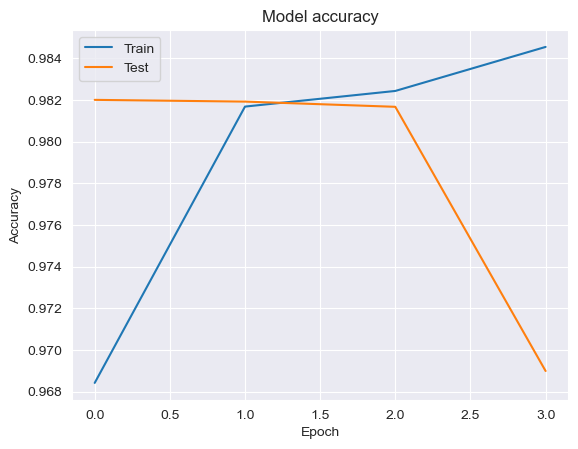

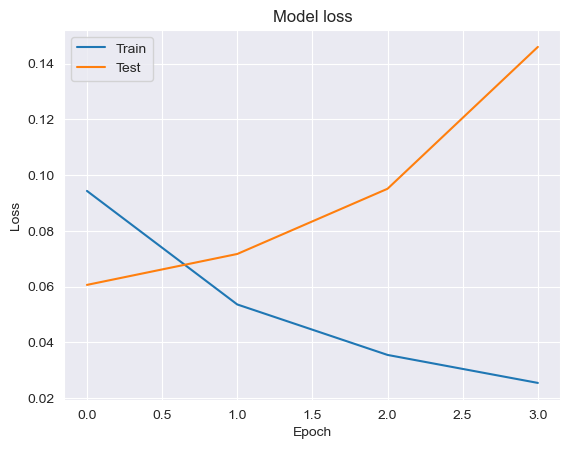

Mean loss: 0.14182117208838463
Mean accuracy: 0.9716221332550049


In [2]:
from sklearn.metrics import classification_report
from keras.utils import pad_sequences
import pandas as pd
import jieba
import tensorflow as tf
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# 读取我们本次实验的文本数据
df = pd.read_csv('../Emotional_text/weibo_sentiment.csv')

# 分词并去除停用词
stop_words = load_stopwords()
df['review'] = df['review'].apply(lambda x: ' '.join(word for word in jieba.cut(x) if word not in stop_words))

# 使用Keras的Tokenizer来转化词语为词向量，这里我们选择出现频率前25000个词作为词袋
tokenizer = Tokenizer(num_words=25000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['review'])
seq = tokenizer.texts_to_sequences(df['review'])

# 补齐每个样本序列，使其长度一样来方便后续的计算
max_len = 280
seq = pad_sequences(seq, maxlen=max_len, truncating='post')

# 划分数据集，这里我们使用十折交叉验证，循环十次训练
labels = df['label']
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
losses = []
accs = []
for train_idx, test_idx in kfold.split(seq, labels):
    # 划分训练集和测试集
    train_seq, test_seq = seq[train_idx], seq[test_idx]
    train_labels, test_labels = labels.iloc[train_idx], labels.iloc[test_idx]

    # 建立一个神经网络模型，一层层添加神经元层
    model = Sequential()
    model.add(Embedding(25000, 150, input_length=max_len))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    # 编译刚刚建立的卷积神经网络模型
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # 设置 EarlyStopping 和 ReduceLROnPlateau 来避免过拟合
    early_stop = EarlyStopping(monitor='val_loss', patience=3)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

    # 训练以及验证卷积神经网络模型的效果
    history = model.fit(train_seq, tf.keras.utils.to_categorical(train_labels), batch_size=128, epochs=20, validation_data=(test_seq, tf.keras.utils.to_categorical(test_labels)), callbacks=[early_stop, reduce_lr], verbose=0)

    # 评估本实验建立的卷积神经网络模型的训练结果的各项参数
    loss, accuracy = model.evaluate(test_seq, tf.keras.utils.to_categorical(test_labels))
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    losses.append(loss)
    accs.append(accuracy)
    y_pred = np.argmax(model.predict(test_seq), axis=-1)
    print(classification_report(test_labels, y_pred))

    # 绘制训练集和测试集的损失和准确率变化曲线
    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

print('Mean loss:', np.mean(losses))
print('Mean accuracy:', np.mean(accs))